In [1]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree
import sys
import time

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512 # encoder dim
h_P_dim = 512 # decoder dim

# problem dimenc_dimsions
dim = 4 # (x, y, xdot, ydot)
dataElements = dim+3*3+2*dim # sample (4D), gap1 (2D, 1D orientation), gap2, gap3, init (4D), goal (4D)

z_dim = 2 # latent dim
X_dim = dim # samples dim

In [3]:
# read in data
filename = '/home/oscar_palfelt/MSc_thesis/LearnedSamplingDistributions/narrowDataFile.txt'
data = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,3,4,6,7,8,9,10,11,12,13,14,15,16,18,19,21,22,24,25])
numEntries = data.shape[0]

In [4]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
end = time.time();
print('Time: ', end-start)
    
cs = np.concatenate((data[0:numEntries,dim+3*dimW:dataElements], conditionsOcc), axis=1) # occ(11x11), init (4D), goal (4D)
c_dim = cs.shape[1]

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
Time:  30.808541536331177


In [5]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y

network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_distributions/network_xy_1st.pt')

In [6]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(2.0))
     return obj


class MyStateSampler(ob.StateSampler):
    def __init__(self, space):
         super(MyStateSampler, self).__init__(space)
         self.name_ = "my sampler"
         self.bounds = space.getBounds()

    def sampleUniform(self, state):
        if np.random.uniform() < p:
            rndState = y[np.random.randint(low=0, high=y.shape[0]-1), :]
            state.setYaw(float(int(rndState[3] > 0) * np.arccos(np.dot(rndState[2:4] / np.linalg.norm(rndState[2:4]), [1, 0])))) # this is wrong
        else:
            rndState = [np.random.uniform(low=self.bounds.low[0], high=self.bounds.high[0]),
                        np.random.uniform(low=self.bounds.low[1], high=self.bounds.high[1]),
                        np.random.uniform(low=-np.pi, high=np.pi)]
            state.setYaw(rndState[2])

        state.setX(float(rndState[0]))
        state.setY(float(rndState[1]))


def allocStateSampler(space):
    return MyStateSampler(space)


def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def problemDef():
    # construct the state space we are planning in
    space = ob.DubinsStateSpace(turningRadius=0.1)

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # set state sampler
    space.setStateSamplerAllocator(ob.StateSamplerAllocator(allocStateSampler))

    # define a simple setup class
    ss = og.SimpleSetup(space)
    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)
    ss.setPlanner(planner)

    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState):

    space = ob.DubinsStateSpace(turningRadius=0.1)
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(5.0)
    exactSolTerminationCondition = ob.exactSolnPlannerTerminationCondition(planObj.getProblemDefinition())

    planObj.solve(ob.plannerOrTerminationCondition(exactSolTerminationCondition, timeTerminationCondition))

         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp
         at line 258 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/base/src/Planner.cpp
Error:   RRTstar: There are no valid initial states!
         at line 193 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp
         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Debug:   RRTstar: Planner range detected to be 0.596436
Debug:   RRTstar: Discarded start state Compound state [
RealVectorState [0.802524 0.880733]
SO2State [-3.14159]
]

Info:    No solution found after 0.000044 seconds
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 2.00000.
Info:    RRTstar: Initial k-nearest value of 45
Info:    RRTstar: Found an initial solution with a cost of 1.10 in 504 iterations (187 vertices in the graph)Start states:
Compound state [
RealVectorState [0.532891 0.857701]
SO2State [-3.14159]
]
Goal state, threshold = 0.1, memory address = 0xedc57e20, state = 
Compound state [
RealVectorState [0.012576 0.0180488]
SO2State [-3.14159]
]
Optimization Objective: Path Length @0x7efad7aaaac0
Optimization Threshold: 2
Average state cost: 0
There are 1 solutions


Info:    RRTstar: Created 186 new states. Checked 17391 rewire options. 1 goal states in tree. Final solution cost 1.102
Info:    Solution found in 0.310586 seconds


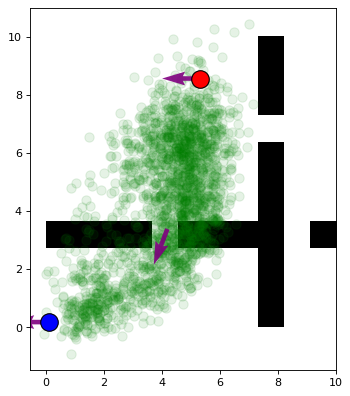

Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 2.00000.
Info:    RRTstar: Initial k-nearest value of 45


         at line 101 in /home/oscar_palfelt/MSc_thesis/ompl/src/ompl/geometric/planners/rrt/src/RRTstar.cpp


Info:    RRTstar: Found an initial solution with a cost of 1.12 in 881 iterations (400 vertices in the graph)
Info:    RRTstar: Created 399 new states. Checked 79634 rewire options. 1 goal states in tree. Final solution cost 1.118
Info:    Solution found in 1.236305 seconds
Start states:
Compound state [
RealVectorState [0.532891 0.857701]
SO2State [-3.14159]
]
Goal state, threshold = 0.1, memory address = 0xee6f0980, state = 
Compound state [
RealVectorState [0.012576 0.0180488]
SO2State [-3.14159]
]
Optimization Objective: Path Length @0x7efad7aaaac0
Optimization Threshold: 2
Average state cost: 0
There are 1 solutions



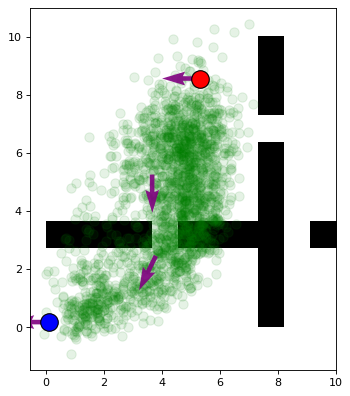

In [23]:
# compare performance of planning w/ and w/out the learned distributions

nTests = 1

nSamples = 2000 # number of samples to draw in latent space

planObj = problemDef()
minCostThreshold = 0.0 # set minimumcost threshold to only attempt complex planning scenarios

nTotIterations = np.array([0, 0])
nCompletedTests = 0

plotPaths = True
while nCompletedTests <= nTests - 1:

    planIdx = np.random.randint(0,numEntries-1); # chose a random test scenario

    c_sample_seed = cs[planIdx,:]
    c_sample = torch.from_numpy(np.repeat([c_sample_seed],nSamples,axis=0)).float().to(DEVICE)

    # directly sample from the latent space
    y = network(torch.randn(nSamples, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy()

    start = data[planIdx, 13:16]
    goal = data[planIdx, 17:20]
    if start[0] < goal[0]:
        start[-1] = 0
        goal[-1] = 0
    else:
        start[-1] = -np.pi
        goal[-1] = -np.pi
        
    occGrid = np.rot90(c_sample_seed[-gridSize*gridSize:].reshape(gridSize, gridSize))

    nIterations = np.array([0, 0])
    for i, p in enumerate([0., 0.6]):
        planObj.clear()
        plan(planObj, initState=start, goalState=goal)

        if planObj.getProblemDefinition().hasExactSolution():
            if planObj.getPlanner().bestCost().value() > minCostThreshold:
                sol = np.loadtxt(StringIO(planObj.getProblemDefinition().getSolutionPath().printAsMatrix()))
                nIterations[i] += planObj.getPlanner().numIterations()
                
                if plotPaths:
                    fig1 = plt.figure(figsize=(10,6), dpi=80)
                    ax1 = fig1.add_subplot(111, aspect='equal')
                    ax1.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
                    ax1.scatter(y[:,0] * (gridSize - 1), y[:,1] * (gridSize - 1), color="green", s=70, alpha=0.1)
                    ax1.quiver(sol[:, 0] * (gridSize - 1), sol[:, 1] * (gridSize - 1), np.cos(sol[:,2]), np.sin(sol[:,2]), color="purple", scale=8.0, width=0.015, alpha=0.9)
                    ax1.scatter(start[0] * (gridSize - 1), start[1] * (gridSize - 1), color="red", s=250, edgecolors='black') # init
                    ax1.scatter(goal[0] * (gridSize - 1), goal[1] * (gridSize - 1), color="blue", s=250, edgecolors='black') # goal
                    plt.show()
            else:
                nIterations = np.array([0, 0])
                nCompletedTests -= 1
                break 
        else:
            nIterations = np.array([0, 0])
            nCompletedTests -= 1
            break
    
    nTotIterations += nIterations
    nCompletedTests += 1


In [22]:
print("Average # of iterations: ", nTotIterations / nTests)
# p = [0., 0.8] -> average [827, 483] for minCostThreshold = 1.2, nTests = 120
# p = [0., 0.6] -> average [1150, 721] for minCostThreshold = 1.4, nTests = 100

Average # of iterations:  [ 61. 330.]
